In [19]:
import numpy as np
import pandas as pd
import open3d
import os
import tqdm
import matplotlib.pyplot as plt
import utils.helpers as helpers
import utils.fread as fread
import utils.registration as registration
import copy

from utils.depth_camera import DepthCamera
from utils.config import Config

import utils.registration as registration
import utils.fread as fread
import utils.FCGF as FCGF
import utils.helpers as helpers

from scipy import signal
from scipy.ndimage import gaussian_filter1d

In [2]:
config = Config(
    sequence_dir="data/raw_data",
    feature_dir="data/features",
    output_dir="data/trajectories/estimated_imu+depth",
    experiment="exp_8",
    trial="trial_2",
    subject="subject-1",
    sequence="03",
    groundtruth_dir="data/trajectories/groundtruth",
)

config.voxel_size=0.03
config.target_fps=20
config.min_std=0.5

In [65]:
pose_file = os.path.join(config.get_groundtruth_dir(), f"{config.get_file_name()}.pose.npz")
motion_dir = config.get_motion_dir(include_secondary=False)

In [81]:
accel_df = pd.read_csv(os.path.join(motion_dir, "accel.csv"))
gyro_df = pd.read_csv(os.path.join(motion_dir, "gyro.csv"))

accel_df.drop_duplicates("timestamp", inplace=True)
gyro_df.drop_duplicates("timestamp", inplace=True)

gravity_df = pd.DataFrame(columns=["timestamp", "x", "y", "z"])

imu_df = pd.merge(accel_df, gyro_df, on="timestamp", suffixes=("a", "g"))

raw_accel_df = imu_df[["timestamp", "xa", "ya", "za"]].copy()

frame_rate = accel_df.shape[0] / (accel_df.timestamp.values[-1] - accel_df.timestamp.values[0]) * 1000

win_len = int(frame_rate * 4) # 4 seconds window

gravity = imu_df.iloc[:win_len, [1, 2, 3]].mean().values
# compute dt in seconds
imu_df.loc[:, "dt"] = np.concatenate([[0], (imu_df.timestamp.values[1:] - imu_df.timestamp.values[:-1]) / 1000])
# remove first row as the dt is 0
imu_df = imu_df.iloc[1:]
# reset index in pandas data frame
imu_df.reset_index(drop=True, inplace=True)

# Fill 0 for displacement, angles, and coordinates
imu_df.loc[:, "x"] = np.zeros(len(imu_df))
imu_df.loc[:, "y"] = np.zeros(len(imu_df))
imu_df.loc[:, "z"] = np.zeros(len(imu_df))

print(f"Frame rate: {frame_rate:.2f} Hz")
print(f"Window length: {win_len} frames")

Frame rate: 400.21 Hz
Window length: 1600 frames


In [82]:
# apply gaussian filter to smooth acceleration and gyro data
imu_df.loc[:, "xa"] = gaussian_filter1d(imu_df.xa.values, sigma=10)
imu_df.loc[:, "ya"] = gaussian_filter1d(imu_df.ya.values, sigma=10)
imu_df.loc[:, "za"] = gaussian_filter1d(imu_df.za.values, sigma=10)
imu_df.loc[:, "xg"] = gaussian_filter1d(imu_df.xg.values, sigma=10)
imu_df.loc[:, "yg"] = gaussian_filter1d(imu_df.yg.values, sigma=10)
imu_df.loc[:, "zg"] = gaussian_filter1d(imu_df.zg.values, sigma=10)

In [83]:
# calculate displacement and rotation
rotation_matrix = np.identity(4)
velocity = [0, 0, 0]

for i in tqdm.tqdm(range(1, len(imu_df))):
    v = imu_df.iloc[i].values
    da = np.degrees([v[j + 4] * v[7] for j in range(3)])
    
    acceleration = imu_df.iloc[i, [1, 2, 3]].values
    gravity_rotated = np.dot(rotation_matrix, np.array([*gravity, 1]))
    acceleration = acceleration - gravity_rotated[:3]
    
    imu_df.iloc[i, 1] = acceleration[0]
    imu_df.iloc[i, 2] = acceleration[1]
    imu_df.iloc[i, 3] = acceleration[2]
    
    # rotation_matrix = helpers.rotate_transformation_matrix(rotation_matrix, da[0], da[1], da[2])

accel_mavg = imu_df[["xa", "ya", "za"]].rolling(window=win_len).mean()
accel_mavg.fillna(0, inplace=True)

imu_df[["xa", "ya", "za"]] = imu_df[["xa", "ya", "za"]] - accel_mavg

100%|██████████| 7999/7999 [00:02<00:00, 3153.72it/s]


In [84]:
imu_df = imu_df.iloc[win_len:]

In [70]:
# calculate displacement and rotation
rotation_matrix = np.identity(4)

velocity = [0, 0, 0]

for i in tqdm.tqdm(range(1, len(imu_df))):
    v = imu_df.iloc[i].values
    
    dt = v[7]
    
    # current displacement and rotation
    da = np.degrees([v[j + 4] * dt for j in range(3)])
    
    acceleration = imu_df.iloc[i, [1, 2, 3]].values

    d = [(velocity[j] * dt) + (0.5 * acceleration[j] * dt * dt) for j in range(3)]
    d = np.dot(rotation_matrix, np.array([*d, 1]))
    
    imu_df.iloc[i, 8] = imu_df.iloc[i - 1, 8] + d[0]
    imu_df.iloc[i, 9] = imu_df.iloc[i - 1, 9] + d[1]
    imu_df.iloc[i, 10] = imu_df.iloc[i - 1, 10] + d[2]
    
    velocity = [velocity[j] + acceleration[j] * dt for j in range(3)]
    
    rotation_matrix = helpers.rotate_transformation_matrix(rotation_matrix, da[0], da[1], da[2])

100%|██████████| 6399/6399 [00:02<00:00, 2327.62it/s]


In [57]:
xyz = imu_df.loc[:, ["x", "y", "z"]].values
pcd = helpers.make_pcd(xyz)
pcd.paint_uniform_color([1, 0, 0])

open3d.visualization.draw_geometries([pcd])

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 


In [71]:
# load ground truth trajectory
sequence_ts = fread.get_timstamps_from_images(config.get_sequence_dir(include_secondary=False), ext=".depth.png")
start_t = helpers.nearest(sequence_ts, imu_df.timestamp.values[0])
start_index = np.where(sequence_ts == start_t)[0][0]

poses = np.load(pose_file)
trajectory_t = poses["trajectory_t"]
local_t = poses["local_t"]

pcd_gt = helpers.make_pcd(trajectory_t[start_index:, :3, 3])
pcd_gt.paint_uniform_color([0, 1, 0])

PointCloud with 409 points.

In [72]:
gt_xyz = trajectory_t[start_index:, :3, 3]
gt_timestamps = sequence_ts[start_index:]

gt_velocity = np.diff(gt_xyz, axis=0) * 1e3 / np.repeat(np.expand_dims(np.diff(gt_timestamps), axis=0), 3, axis=0).T
gt_acceleration = np.diff(gt_velocity, axis=0) * 1e3 / np.repeat(np.expand_dims(np.diff(gt_timestamps[1:]), axis=0), 3, axis=0).T

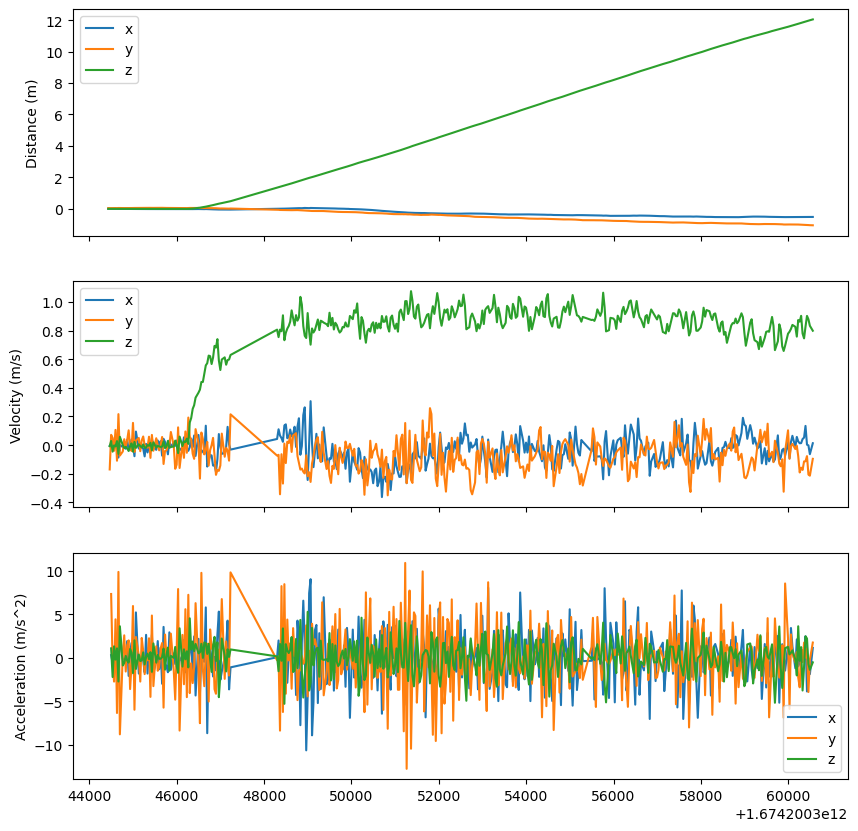

In [73]:
fig, ax = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

ax[0].plot(gt_timestamps, gt_xyz[:, 0], label="x")
ax[0].plot(gt_timestamps, gt_xyz[:, 1], label="y")
ax[0].plot(gt_timestamps, gt_xyz[:, 2], label="z")
ax[0].set_ylabel("Distance (m)")
ax[0].legend()

ax[1].plot(gt_timestamps[1:], gt_velocity[:, 0], label="x")
ax[1].plot(gt_timestamps[1:], gt_velocity[:, 1], label="y")
ax[1].plot(gt_timestamps[1:], gt_velocity[:, 2], label="z")
ax[1].set_ylabel("Velocity (m/s)")
ax[1].legend()

ax[2].plot(gt_timestamps[2:], gt_acceleration[:, 0], label="x")
ax[2].plot(gt_timestamps[2:], gt_acceleration[:, 1], label="y")
ax[2].plot(gt_timestamps[2:], gt_acceleration[:, 2], label="z")
ax[2].set_ylabel("Acceleration (m/s^2)")
ax[2].legend()

<AxesSubplot:title={'center':'Gyroscope'}, xlabel='timestamp'>

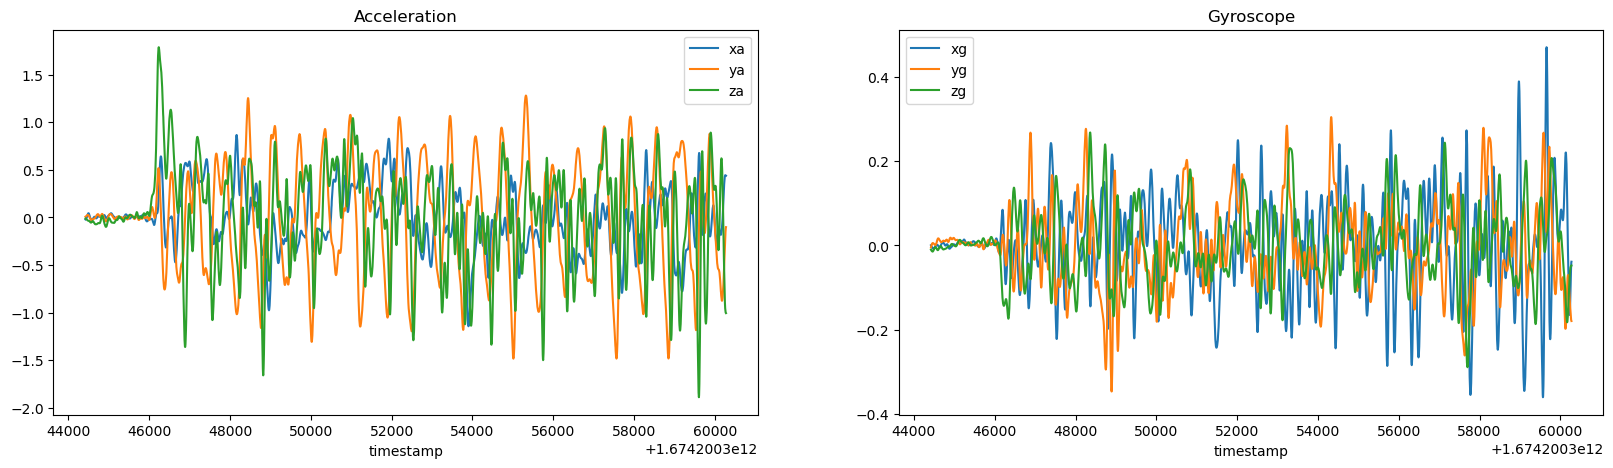

In [80]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

imu_df.plot(x="timestamp", y=["xa", "ya", "za"], ax=ax[0], title="Acceleration")
imu_df.plot(x="timestamp", y=["xg", "yg", "zg"], ax=ax[1], title="Gyroscope")

Text(0.5, 0.98, 'Ground Truth vs IMU')

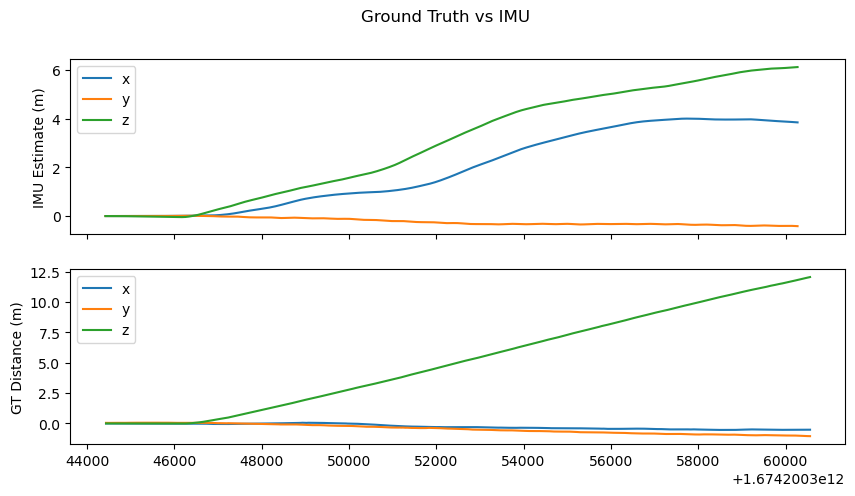

In [74]:
fig, ax = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

imu_df.plot(x="timestamp", y=["x", "y", "z"], xlabel="Timestamp", ylabel="IMU Estimate (m)", ax=ax[0])

ax[1].plot(gt_timestamps, gt_xyz[:, 0], label="x")
ax[1].plot(gt_timestamps, gt_xyz[:, 1], label="y")
ax[1].plot(gt_timestamps, gt_xyz[:, 2], label="z")
ax[1].set_ylabel("GT Distance (m)")
ax[1].legend()

fig.suptitle("Ground Truth vs IMU")

In [103]:
depth_camera = DepthCamera("secondary", os.path.join(config.sequence_dir, config.experiment, "metadata", "device-0-aligned.json"))

In [105]:
local_pcds = []

for t in tqdm.trange(len(sequence_ts)):
    depth_img_file = os.path.join(config.get_sequence_dir(include_secondary=False), f"frame-{sequence_ts[t]}.depth.png")
    pcd = depth_camera.depth_to_point_cloud(depth_img_file)
    pcd = pcd.voxel_down_sample(voxel_size=0.03)
    local_pcds.append(pcd)

100%|██████████| 474/474 [00:13<00:00, 35.66it/s]


In [69]:
trajectory_pcd = []

for t in tqdm.trange(len(sequence_ts)):
    pcd = copy.deepcopy(local_pcds[t])
    pcd.transform(trajectory_t[t])
    trajectory_pcd.append(pcd)
    
trajectory_pcd = helpers.merge_pcds(trajectory_pcd, config.voxel_size)

100%|██████████| 490/490 [00:00<00:00, 11218.39it/s]


In [70]:
open3d.visualization.draw_geometries([trajectory_pcd])

Debug code for one instance

In [ ]:
start_t = 200
end_t = 201

source = copy.deepcopy(local_pcds[end_t])
target = copy.deepcopy(local_pcds[start_t])

source.paint_uniform_color([1, 0.706, 0])
target.paint_uniform_color([0, 0.651, 0.929])

gt_transform = np.dot(helpers.inv_transform(trajectory_t[start_t]), trajectory_t[end_t])

registration.view(source, target, gt_transform)

velocity = gt_transform[:3, 3] * 1e3 / (sequence_ts[end_t] - sequence_ts[start_t])
print(f"dt={sequence_ts[end_t] - sequence_ts[start_t]:.2f} ms, velocity={velocity}")

start_t = start_t + 1
end_t = end_t + 10

imu_slice_df = imu_df[(imu_df.timestamp >= sequence_ts[start_t]) & (imu_df.timestamp <= sequence_ts[end_t])]

# calculate displacement and rotation
rotation_matrix = np.identity(4)
translation = np.zeros(3)

for i in tqdm.tqdm(range(len(imu_slice_df))):
    v = imu_slice_df.iloc[i].values
    
    dt = v[7]
    
    # current displacement and rotation
    da = np.degrees([v[j + 4] * dt for j in range(3)])
    
    acceleration = imu_slice_df.iloc[i, [1, 2, 3]].values

    d = [(velocity[j] * dt) + (0.5 * acceleration[j] * dt * dt) for j in range(3)]
    d = np.dot(rotation_matrix, np.array([*d, 1]))
    
    translation = translation + d[:3]
    
    velocity = [velocity[j] + acceleration[j] * dt for j in range(3)]
    
    rotation_matrix = helpers.rotate_transformation_matrix(rotation_matrix, da[0], da[1], da[2])

trans_mat = np.identity(4)
trans_mat[:3, 3] = translation
trans_mat[:3, :3] = rotation_matrix[:3, :3]

source = copy.deepcopy(local_pcds[end_t])
target = copy.deepcopy(local_pcds[start_t])

source.paint_uniform_color([1, 0.706, 0])
target.paint_uniform_color([0, 0.651, 0.929])

refined_transform = registration.icp_refinement(source, target, 0.05, trans_init=trans_mat, max_iteration=50)

registration.view(source, target, trans_mat)

In [108]:
start_t = start_index
end_t = start_index + 1

gt_transform = np.dot(helpers.inv_transform(trajectory_t[start_t]), trajectory_t[end_t])
velocity = gt_transform[:3, 3] * 1e3 / (sequence_ts[end_t] - sequence_ts[start_t])

local_t = [np.identity(4), gt_transform]

for t in tqdm.trange(start_index + 1, len(sequence_ts) - 1):
    start_t, end_t = t, t + 1
    
    imu_slice_df = imu_df[(imu_df.timestamp >= sequence_ts[start_t]) & (imu_df.timestamp <= sequence_ts[end_t])]
    
    # calculate displacement and rotation
    rotation_matrix = np.identity(4)
    translation = np.zeros(3)

    for i in range(len(imu_slice_df)):
        v = imu_slice_df.iloc[i].values
        
        dt = v[7]
        
        # current displacement and rotation
        da = np.degrees([v[j + 4] * dt for j in range(3)])
        
        acceleration = imu_slice_df.iloc[i, [1, 2, 3]].values

        d = [(velocity[j] * dt) + (0.5 * acceleration[j] * dt * dt) for j in range(3)]
        d = np.dot(rotation_matrix, np.array([*d, 1]))
        
        translation = translation + d[:3]
        velocity = [velocity[j] + acceleration[j] * dt for j in range(3)]
        
        rotation_matrix = helpers.rotate_transformation_matrix(rotation_matrix, da[0], da[1], da[2])
        
    trans_mat = np.identity(4)
    trans_mat[:3, 3] = translation
    trans_mat[:3, :3] = rotation_matrix[:3, :3]
    
    source = copy.deepcopy(local_pcds[end_t])
    target = copy.deepcopy(local_pcds[start_t])
    
    refined_transform = registration.icp_refinement(source, target, 0.05, trans_init=trans_mat, max_iteration=50, p2p=True).transformation
    
    velocity = refined_transform[:3, 3] * 1e3 / (sequence_ts[end_t] - sequence_ts[start_t])
    
    # if t % 20 == 0:
    #     registration.view(source, target, refined_transform)
    
    local_t.append(refined_transform)

local_t = np.array(local_t)

100%|██████████| 407/407 [00:15<00:00, 26.00it/s]


In [109]:
trajectory_t = [np.identity(4)]

for t in range(1, len(local_t)):
    trajectory_t.append(np.dot(trajectory_t[t - 1], local_t[t]))
    
trajectory_t = np.array(trajectory_t)

In [110]:
trajectory_pcd = []

for t in range(start_index, len(sequence_ts)):
    pcd = copy.deepcopy(local_pcds[t])
    pcd.transform(trajectory_t[t - start_index])
    trajectory_pcd.append(pcd)
    
trajectory_pcd = helpers.merge_pcds(trajectory_pcd, 0.03)

In [111]:
open3d.visualization.draw_geometries([trajectory_pcd])

In [79]:
xyz_trajectory = trajectory_t[:, :3, 3]
pcd = open3d.geometry.PointCloud()
pcd.points = open3d.utility.Vector3dVector(xyz_trajectory)

open3d.visualization.draw_geometries([pcd])

In [78]:
open3d.visualization.draw_geometries([pcd_gt])

## Deriving gravity vector from PCD registration

In [85]:
sequence_ts = fread.get_timstamps_from_images(config.get_sequence_dir(include_secondary=False), ext=".depth.png")

depth_camera = DepthCamera("secondary", os.path.join(config.sequence_dir, config.experiment, "metadata", "device-0-aligned.json"))

poses = np.load(pose_file)
trajectory_t = poses["trajectory_t"]
local_t = poses["local_t"]

start_ind = 30 * 5
sequence_ts = sequence_ts[start_ind:]

In [86]:
local_pcds = []

for t in tqdm.trange(len(sequence_ts)):
    depth_img_file = os.path.join(config.get_sequence_dir(include_secondary=False), f"frame-{sequence_ts[t]}.depth.png")
    pcd = depth_camera.depth_to_point_cloud(depth_img_file)
    pcd = pcd.voxel_down_sample(voxel_size=0.03)
    local_pcds.append(pcd)

100%|██████████| 324/324 [00:09<00:00, 32.74it/s]


In [10]:
gt_xyz = trajectory_t[start_ind:, :3, 3]
gt_trajectory = helpers.make_pcd(gt_xyz)

In [116]:
open3d.visualization.draw_geometries([gt_trajectory])

In [87]:
gt_velocity = np.diff(gt_xyz, axis=0) * 1e3 / np.diff(sequence_ts).reshape(-1, 1)

ValueError: operands could not be broadcast together with shapes (408,3) (323,1) 

ValueError: x and y must have same first dimension, but have shapes (324,) and (409,)

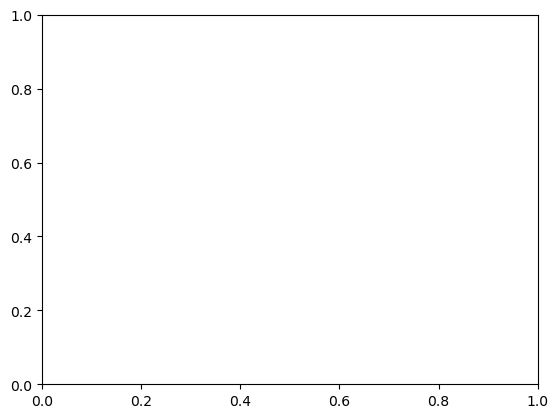

In [88]:
plt.plot(sequence_ts, gt_xyz[:, 0], label="x")
plt.plot(sequence_ts, gt_xyz[:, 1], label="y")
plt.plot(sequence_ts, gt_xyz[:, 2], label="z")

plt.legend()
plt.xlabel("Timestamp")
plt.ylabel("Position (m)")

First second is used to find the gravity vector

In [13]:
elapsed_time = (sequence_ts - sequence_ts[0]) // 1e3

calibration_ts = np.argwhere(elapsed_time == 0).flatten()

In [41]:
calibration_imu_df = imu_df[(imu_df.timestamp >= sequence_ts[calibration_ts[2]]) & (imu_df.timestamp <= sequence_ts[calibration_ts[-1]])]

In [43]:
calibration_imu_df.loc[:, ["xa", "ya", "za"]] = calibration_imu_df[["xa", "ya", "za"]].apply(lambda x: gaussian_filter1d(x, 10), axis=0)

C:\Users\darshanakg.2021\AppData\Local\Temp\ipykernel_2508\2429159700.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calibration_imu_df.loc[:, ["xa", "ya", "za"]] = calibration_imu_df[["xa", "ya", "za"]].apply(lambda x: gaussian_filter1d(x, 10), axis=0)


In [63]:
# velocity
velocity = np.diff(gt_xyz[calibration_ts], axis=0) * 1e3 / np.diff(sequence_ts[calibration_ts]).reshape(-1, 1)
linear_acceleration = np.diff(velocity, axis=0) * 1e3 / np.diff(sequence_ts[calibration_ts][1:]).reshape(-1, 1)
# linear_acceleration = signal.resample(linear_acceleration, calibration_imu_df.timestamp.shape[0], axis=0, domain="freq")

linear_acceleration_resampled = np.zeros((calibration_imu_df.timestamp.shape[0], 3))
linear_acceleration_resampled[:, 0] = np.interp(calibration_imu_df.timestamp.values, sequence_ts[calibration_ts][2:], linear_acceleration[:, 0])
linear_acceleration_resampled[:, 1] = np.interp(calibration_imu_df.timestamp.values, sequence_ts[calibration_ts][2:], linear_acceleration[:, 1])
linear_acceleration_resampled[:, 2] = np.interp(calibration_imu_df.timestamp.values, sequence_ts[calibration_ts][2:], linear_acceleration[:, 2])

In [57]:
linear_acceleration_resampled = gaussian_filter1d(linear_acceleration_resampled.T, sigma=3, axis=0)

In [61]:
linear_acceleration_resampled = linear_acceleration_resampled.T

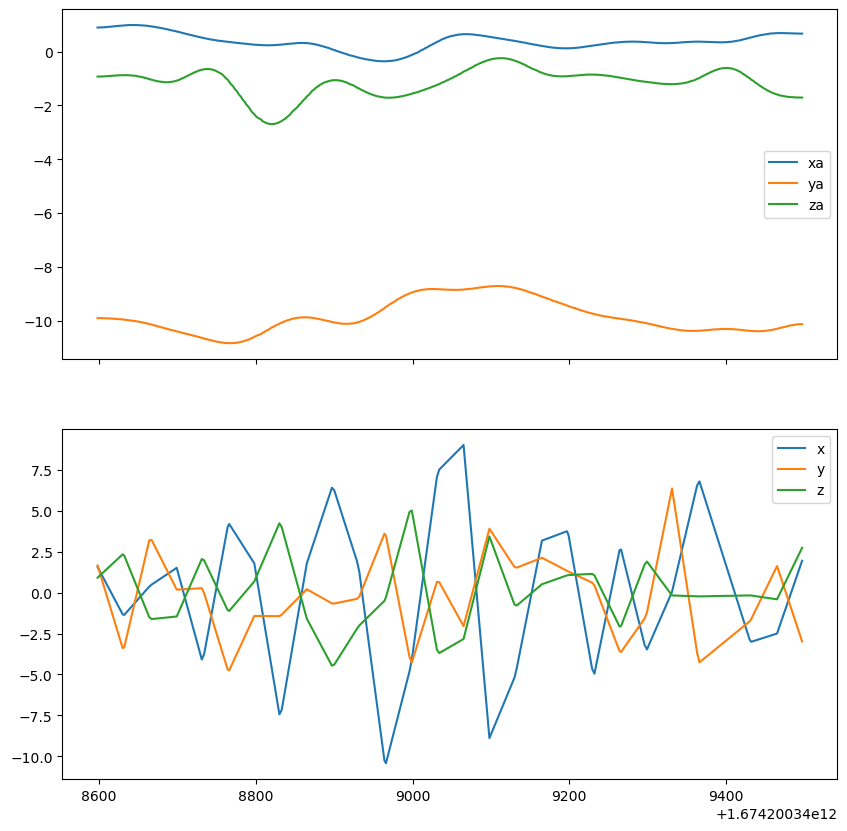

In [64]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

calibration_imu_df.plot(x="timestamp", y=["xa", "ya", "za"], ax=axs[0])

axs[1].plot(calibration_imu_df.timestamp.values, linear_acceleration_resampled[:, 0], label="x")
axs[1].plot(calibration_imu_df.timestamp.values, linear_acceleration_resampled[:, 1], label="y")
axs[1].plot(calibration_imu_df.timestamp.values, linear_acceleration_resampled[:, 2], label="z")
axs[1].legend()  

In [104]:
def rotation_matrix_to_euler_angles(R):
    sy = np.sqrt(R[0,0]**2 + R[1,0]**2)
    singular = sy < 1e-6

    if not singular:
        x = np.arctan2(R[2,1], R[2,2])
        y = np.arctan2(-R[2,0], sy)
        z = np.arctan2(R[1,0], R[0,0])
    else:
        x = np.arctan2(-R[1,2], R[1,1])
        y = np.arctan2(-R[2,0], sy)
        z = 0

    return np.array([x, y, z])

In [189]:
rotation_matrices = trajectory_t[start_ind:, :3, :3][calibration_ts]

euler_angles = np.array([rotation_matrix_to_euler_angles(R) for R in rotation_matrices])
# resampled_euler_angles = signal.resample(euler_angles, calibration_imu_df.timestamp.shape[0], axis=0, domain="time")
# resampled_euler_angles = np.zeros((calibration_imu_df.timestamp.shape[0], 3))
# resampled_euler_angles[:, 0] = np.interp(calibration_imu_df.timestamp.values, sequence_ts[calibration_ts], euler_angles[:, 0])
# resampled_euler_angles[:, 1] = np.interp(calibration_imu_df.timestamp.values, sequence_ts[calibration_ts], euler_angles[:, 1])
# resampled_euler_angles[:, 2] = np.interp(calibration_imu_df.timestamp.values, sequence_ts[calibration_ts], euler_angles[:, 2])

angular_velocity = np.diff(euler_angles, axis=0) * 1e3 / np.diff(sequence_ts[calibration_ts]).reshape(-1, 1)

resampled_angular_velocity = []
for dim in range(3):
    resampled_angular_velocity.append(np.interp(calibration_imu_df.timestamp.values, sequence_ts[calibration_ts][1:], angular_velocity[:, dim]))
    
resampled_angular_velocity = np.array(resampled_angular_velocity).T

# resampled_angular_velocity = signal.resample(resampled_angular_velocity, calibration_imu_df.timestamp.shape[0], axis=0, domain="time")

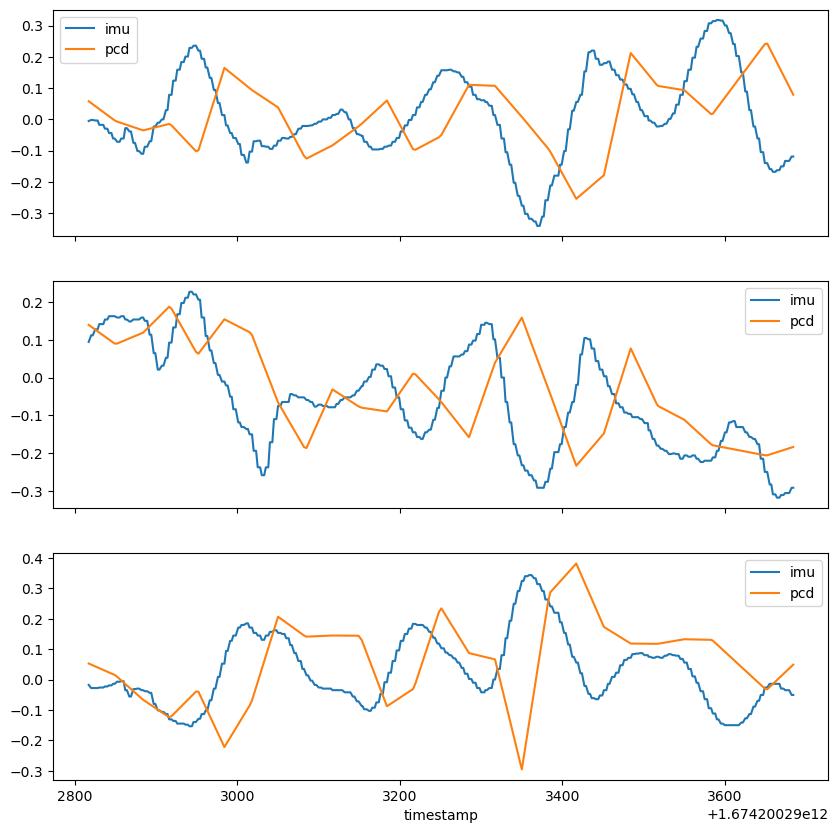

In [190]:
fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

calibration_imu_df.plot(x="timestamp", y="xg", ax=axs[0], label="imu")
axs[0].plot(calibration_imu_df.timestamp.values, resampled_angular_velocity[:, 0], label="pcd")
axs[0].legend()

calibration_imu_df.plot(x="timestamp", y="yg", ax=axs[1], label="imu")
axs[1].plot(calibration_imu_df.timestamp.values, resampled_angular_velocity[:, 1], label="pcd")
axs[1].legend()

calibration_imu_df.plot(x="timestamp", y="zg", ax=axs[2], label="imu")
axs[2].plot(calibration_imu_df.timestamp.values, resampled_angular_velocity[:, 2], label="pcd")
axs[2].legend()

# axs[0].plot(sequence_ts[calibration_ts][1:], angular_velocity[:, 0], label="x")
# axs[0].plot(sequence_ts[calibration_ts][1:], angular_velocity[:, 1], label="y")
# axs[0].plot(sequence_ts[calibration_ts][1:], angular_velocity[:, 2], label="z")

# axs[1].plot(calibration_imu_df.timestamp.values, resampled_angular_velocity[:, 0], label="x")
# axs[1].plot(calibration_imu_df.timestamp.values, resampled_angular_velocity[:, 1], label="y")
# axs[1].plot(calibration_imu_df.timestamp.values, resampled_angular_velocity[:, 2], label="z")

In [191]:
# calculate displacement and rotation
rotation_matrix = np.identity(4)

for i in tqdm.trange(calibration_imu_df.shape[0]):
    v = calibration_imu_df.iloc[i].values
    da = np.degrees([resampled_angular_velocity[i, j] * v[7] for j in range(3)])
    # da = np.degrees([v[j + 4] * v[7] for j in range(3)])
    
    acceleration = calibration_imu_df.iloc[i, [1, 2, 3]].values
    acceleration_rotated = np.dot(rotation_matrix, np.array([*acceleration, 1]))
    acceleration_rotated = acceleration_rotated[:3]
    gravity = acceleration_rotated - linear_acceleration[i]
    print(gravity)    
    rotation_matrix = helpers.rotate_transformation_matrix(rotation_matrix, da[0], da[1], da[2])
    
#     imu_df.iloc[i, 1] = acceleration[0]
#     imu_df.iloc[i, 2] = acceleration[1]
#     imu_df.iloc[i, 3] = acceleration[2]


# accel_mavg = imu_df[["xa", "ya", "za"]].rolling(window=win_len).mean()
# accel_mavg.fillna(0, inplace=True)

# imu_df[["xa", "ya", "za"]] = imu_df[["xa", "ya", "za"]] - accel_mavg

100%|██████████| 351/351 [00:00<00:00, 4077.43it/s]

[ 0.39348499 -8.66759659 -0.31972802]
[ 0.36560918 -8.71752314 -0.32922239]
[ 0.4137791  -8.71009394 -0.32237879]
[ 0.41261707 -8.79957541 -0.31175383]
[ 0.44409644 -8.91499999 -0.30554261]
[ 0.43885024 -9.00121482 -0.27746417]
[ 0.42268907 -9.14294025 -0.25491454]
[ 0.43641834 -9.28605101 -0.24733368]
[ 0.4494493  -9.39372591 -0.19775056]
[ 0.43139497 -9.47101316 -0.16653973]
[ 0.43880701 -9.57256202 -0.13174889]
[ 0.43318047 -9.65491175 -0.13520974]
[ 0.39266287 -9.75342068 -0.13862146]
[ 0.30647805 -9.65077711 -0.24417336]
[ 0.01532497 -9.57823363 -0.28840557]
[-0.08826066 -9.68165963 -0.32328385]
[-0.12382015 -9.64334148 -0.20999844]
[-0.1080581  -9.53001632 -0.16650732]
[-0.12176712 -9.42448814 -0.19534057]
[-0.13618243 -9.34067598 -0.17753316]
[-0.12857026 -9.27686544 -0.19148732]
[-0.06696679 -9.19042279 -0.21684098]
[-0.02779072 -9.05720034 -0.25761181]
[-0.04692166 -9.03974313 -0.26348813]
[-0.08847297 -8.99531377 -0.21561853]
[-0.11418978 -8.99985344 -0.22944176]
[-0.07574219

In [102]:
gravity = calibration_imu_df[["xa", "ya", "za"]].values - linear_acceleration

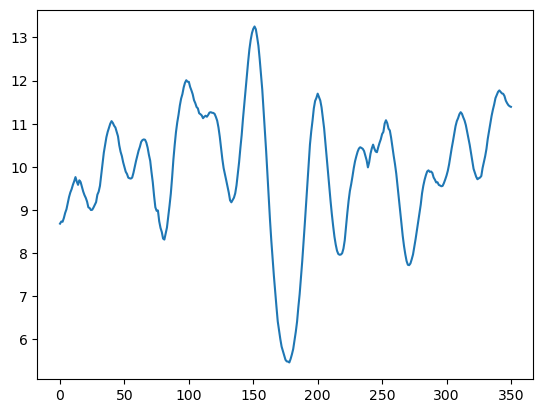

In [103]:
plt.plot(np.linalg.norm(gravity, axis=1))

In [90]:
rotation_matrices = trajectory_t[start_ind:, :3, :3][calibration_ts]

euler_angles = np.array([rotation_matrix_to_euler_angles(R) for R in rotation_matrices])
angular_velocity = np.diff(euler_angles, axis=0) * 1e3 / np.diff(sequence_ts[calibration_ts]).reshape(-1, 1)

angular_velocity = angular_velocity[1:]

angular_velocity = signal.resample(angular_velocity, calibration_imu_df.timestamp.shape[0], axis=0, domain="freq")

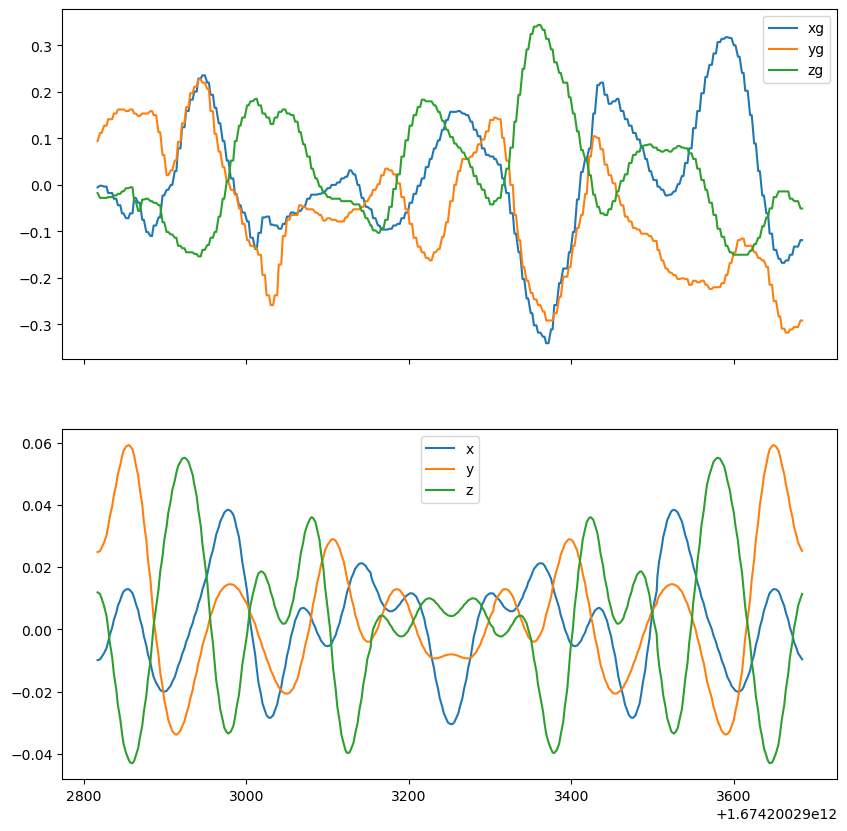

In [92]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

calibration_imu_df.plot(x="timestamp", y=["xg", "yg", "zg"], ax=axs[0])

axs[1].plot(calibration_imu_df.timestamp.values, angular_velocity[:, 0], label="x")
axs[1].plot(calibration_imu_df.timestamp.values, angular_velocity[:, 1], label="y")
axs[1].plot(calibration_imu_df.timestamp.values, angular_velocity[:, 2], label="z")

axs[1].legend()